In [6]:
pip install keras-tuner --upgrade

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model

from keras import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

tf.get_logger().setLevel('INFO')

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Read in the data
def read_file(filename):
    directory = '/content/drive/My Drive/learning_data/'
    location = directory + filename+'.csv'
    df = pd.read_csv(location, index_col=False)
    return df


In [10]:
## Read in all data files
X_test = read_file('X_test_yields')
X_val = read_file('X_val_yields')
Y_test = read_file('Y_test_yields')
Y_train = read_file('Y_train_yields')
Y_val = read_file('Y_val_yields')
X_train = read_file('X_train_yields')

In [11]:
## print shapes
print('\nX_train:',X_train.shape,
      '\nY_train:',Y_train.shape,
      '\nX_val:',X_val.shape,
      '\nY_val:',Y_val.shape,
      '\nX_test:',X_test.shape,
      '\nY_test:',Y_test.shape
      )


X_train: (17727, 1000) 
Y_train: (17727, 1) 
X_val: (1479, 1000) 
Y_val: (1479, 1) 
X_test: (603, 1000) 
Y_test: (603, 1)


In [12]:
X_train_clean = X_train[[
 'state_ansi',
 'county_ansi',
 'ag_district_code',
 'state_county',
 'all_ge_var',
 'ht_only',
 'bt_only',
 'stacked_genes',
 'jan_rain',
 'feb_rain',
 'mar_rain',
 'apr_rain',
 'may_rain',
 'jun_rain',
 'jul_rain',
 'aug_rain',
 'sep_rain',
 'oct_rain',
 'nov_rain',
 'dec_rain',
 'jan_temp',
 'feb_temp',
 'mar_temp',
 'apr_temp',
 'may_temp',
 'jun_temp',
 'jul_temp',
 'aug_temp',
 'sep_temp',
 'oct_temp',
 'nov_temp',
 'dec_temp'
]]

Creating defs for making reproduceable datasets to run many models to find the best predictions

In [13]:
## Create a list of columns that we are keeping

cols=[
 'state_ansi',
 'county_ansi',
 'ag_district_code',
 'all_ge_var',
 'state_county',
 'ht_only',
 'bt_only',
 'stacked_genes',
 'jan_rain',
 'feb_rain',
 'mar_rain',
 'apr_rain',
 'may_rain',
 'jun_rain',
 'jul_rain',
 'aug_rain',
 'sep_rain',
 'oct_rain',
 'nov_rain',
 'dec_rain',
 'jan_temp',
 'feb_temp',
 'mar_temp',
 'apr_temp',
 'may_temp',
 'jun_temp',
 'jul_temp',
 'aug_temp',
 'sep_temp',
 'oct_temp',
 'nov_temp',
 'dec_temp'
]

In [14]:
def col_keep(col_list,X):
  """takes a list of columns and the X df and returns only the wanted columns"""
  dropped_col = X[col_list]
  return dropped_col

In [15]:
## Create a function that removes the NAs from the below function

def remove_na(X,Y):
  """takes X and Y for either training / validation / test sets and removes na rows for both"""
  na_idx = X.isna().any(axis=1)
  Y_clean = Y[~na_idx]
  X_clean = X[~na_idx]

  return X_clean, Y_clean


Here we will use embeddings to identify locations at the state, county, and state-county level as well as analyze rain data

In [16]:
## Process - start with a linear model to understand what would be the
## best options for ML and get to know the data better

In [17]:
### create X train,test,val datasets with only the wanted columns
## Keeping only the ge data

X_train_cols = col_keep(cols,X_train)
X_train_cols.shape
X_val_cols = col_keep(cols,X_val)
X_val_cols.shape
X_test_cols = col_keep(cols,X_test)
X_test_cols.shape

print('X_train_ge:', X_train_cols.shape,
      '\nX_val_ge:',X_val_cols.shape,
      '\nX_test_ge:',X_test_cols.shape
      )

X_train_ge: (17727, 32) 
X_val_ge: (1479, 32) 
X_test_ge: (603, 32)


In [18]:
## Removing the nulls from datasets:

## Train
X_train_cols_clean, Y_train_cols_clean = remove_na(X_train_cols,Y_train)
print('X_train_ge_clean:', X_train_cols_clean.shape, '\nY_train_cols_clean:', Y_train_cols_clean.shape)

X_val_cols_clean, Y_val_cols_clean = remove_na(X_val_cols,Y_val)
print('X_val_ge_clean:', X_val_cols_clean.shape, '\nY_val_cols_clean:', Y_val_cols_clean.shape)

X_test_cols_clean, Y_test_cols_clean= remove_na(X_test_cols,Y_test)
print('X_test_ge_clean:', X_test_cols_clean.shape, '\nY_test_cols_clean:', Y_test_cols_clean.shape)




X_train_ge_clean: (12418, 32) 
Y_train_cols_clean: (12418, 1)
X_val_ge_clean: (1092, 32) 
Y_val_cols_clean: (1092, 1)
X_test_ge_clean: (446, 32) 
Y_test_cols_clean: (446, 1)


In [19]:
### Begin investigating Rain data

In [20]:
X_train_rain_only = X_train_cols_clean[['jan_rain',
 'feb_rain',
 'mar_rain',
 'apr_rain',
 'may_rain',
 'jun_rain',
 'jul_rain',
 'aug_rain',
 'sep_rain',
 'oct_rain',
 'nov_rain',
 'dec_rain']]


<Axes: >

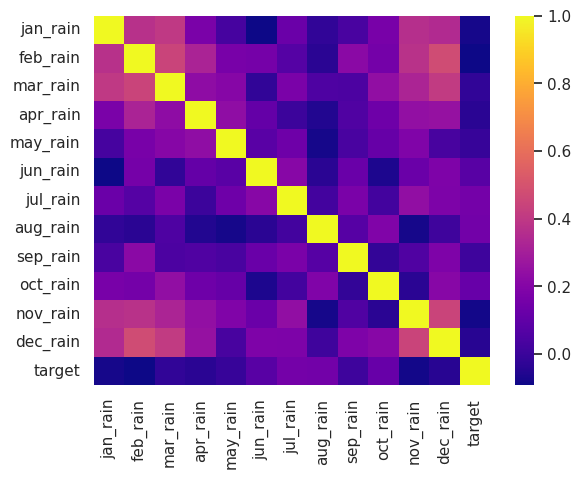

In [21]:

comb_df = X_train_rain_only.copy()
comb_df['target'] = pd.qcut(Y_train_cols_clean['yield_bu_acre'], q=3, labels=['0','1','2']).astype(int)
corr = comb_df.corr()
sns.heatmap(corr,annot=False, fmt=".2f", cmap="plasma")

Using the heat mpa i see only june - oct rain correlating the most, going to do avg, and sum columns for each

In [22]:
X_train_cols_clean.loc[:,'summer_rain_sum'] = X_train_cols_clean[['jun_rain',
 'jul_rain',
 'aug_rain',
 'sep_rain',
 'oct_rain']].sum(axis=1)



/tmp/ipython-input-103675323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cols_clean.loc[:,'summer_rain_sum'] = X_train_cols_clean[['jun_rain',


In [23]:
## adding summer rain average
X_train_cols_clean.loc[:,'summer_rain_avg'] = X_train_cols_clean[['jun_rain',
 'jul_rain',
 'aug_rain',
 'sep_rain',
 'oct_rain']].mean(axis=1)

/tmp/ipython-input-2928133902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cols_clean.loc[:,'summer_rain_avg'] = X_train_cols_clean[['jun_rain',


In [24]:
## Drop rain columns not needed
X_train_cols_clean=X_train_cols_clean.drop(columns = ['jan_rain',
 'feb_rain',
 'mar_rain',
 'apr_rain',
 'may_rain',
 'jun_rain',
 'jul_rain',
 'aug_rain',
 'sep_rain',
 'oct_rain',
 'nov_rain',
 'dec_rain'])

X_train_cols_clean.columns

Index(['state_ansi', 'county_ansi', 'ag_district_code', 'all_ge_var',
       'state_county', 'ht_only', 'bt_only', 'stacked_genes', 'jan_temp',
       'feb_temp', 'mar_temp', 'apr_temp', 'may_temp', 'jun_temp', 'jul_temp',
       'aug_temp', 'sep_temp', 'oct_temp', 'nov_temp', 'dec_temp',
       'summer_rain_sum', 'summer_rain_avg'],
      dtype='object')

<Axes: >

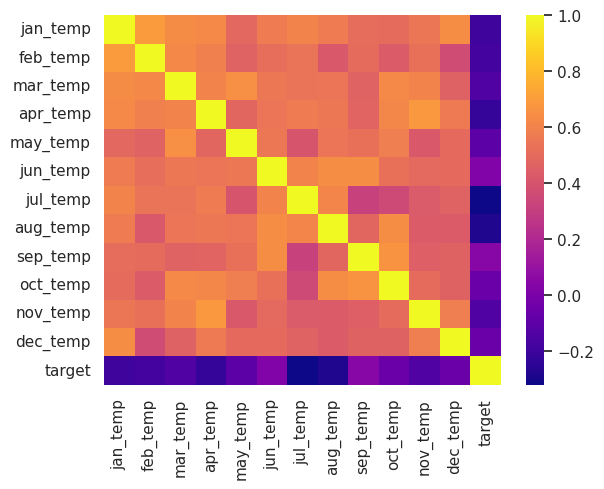

In [25]:
## analyze temperature similar to rain

X_train_temp_only = X_train_cols_clean[['jan_temp',
 'feb_temp',
 'mar_temp',
 'apr_temp',
 'may_temp',
 'jun_temp',
 'jul_temp',
 'aug_temp',
 'sep_temp',
 'oct_temp',
 'nov_temp',
 'dec_temp']]

comb_df = X_train_temp_only.copy()
comb_df['target'] = pd.qcut(Y_train_cols_clean['yield_bu_acre'], q=10, labels=['0','1','2','3','4','5','6','7','8','9']).astype(int)
corr = comb_df.corr()
sns.heatmap(corr,annot=False, fmt=".2f", cmap="plasma")


In [26]:
## averaging spring and fall temps
X_train_cols_clean.loc[:, 'spring_temp_avg'] = X_train_cols_clean[['may_temp','jun_temp']].mean(axis=1)
X_train_cols_clean.loc[:, 'fall_temp_avg'] = X_train_cols_clean[['sep_temp', 'oct_temp']].mean(axis=1)

In [27]:
X_train_cols_clean=X_train_cols_clean.drop(columns =
 ['jan_temp',
 'feb_temp',
 'mar_temp',
 'apr_temp',
 'may_temp',
 'jun_temp',
 'jul_temp',
 'aug_temp',
 'sep_temp',
 'oct_temp',
 'nov_temp',
 'dec_temp',
 'bt_only',
'ht_only',
 ])

X_train_cols_clean.columns

Index(['state_ansi', 'county_ansi', 'ag_district_code', 'all_ge_var',
       'state_county', 'stacked_genes', 'summer_rain_sum', 'summer_rain_avg',
       'spring_temp_avg', 'fall_temp_avg'],
      dtype='object')

In [28]:
## encode state_county -> using ordinal encoder so it will handle unknownv county-state values in the dataset

ord_state_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_cols_clean['state_county_id'] = ord_state_encoder.fit_transform(X_train_cols_clean[['state_county']])

In [29]:
X_train_cols_clean.columns

Index(['state_ansi', 'county_ansi', 'ag_district_code', 'all_ge_var',
       'state_county', 'stacked_genes', 'summer_rain_sum', 'summer_rain_avg',
       'spring_temp_avg', 'fall_temp_avg', 'state_county_id'],
      dtype='object')

In [30]:
## embed location columns
embed_cols = ['state_ansi','ag_district_code','state_county_id']
input_dims = {col: X_train_cols_clean[col].nunique() for col in embed_cols}
print(input_dims)

{'state_ansi': 7, 'ag_district_code': 9, 'state_county_id': 657}


In [31]:
## data pre-processing / formatting: z-scalar formatting for temp and rain data
## create df for each column

numeric_preprocessor = ColumnTransformer(
    transformers = [
        ('summer_rain_sum_scale', StandardScaler(),['summer_rain_sum']),
        ('summer_rain_avg_scale',StandardScaler(),['summer_rain_avg']),
        ('spring_temp_avg_scale',StandardScaler(),['spring_temp_avg']),
        ('fall_temp_avg_scale',StandardScaler(),['fall_temp_avg']),
        ('stacked_genes_scale',MinMaxScaler(),['stacked_genes']),
        ('all_ge_var_scale', MinMaxScaler(),['all_ge_var'])
    ],
    remainder = 'passthrough'
)

X_train_scaled = numeric_preprocessor.fit_transform(X_train_cols_clean)


# adding column names back for now.
transformed_cols = ['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg', 'fall_temp_avg',
                    'stacked_genes', 'all_ge_var']
passthrough_cols = [col for col in X_train_cols_clean.columns if col not in transformed_cols]
output_columns = transformed_cols + passthrough_cols


# final scaled DF:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=output_columns, index=X_train_cols_clean.index)

X_train_scaled_df.columns

Index(['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg',
       'fall_temp_avg', 'stacked_genes', 'all_ge_var', 'state_ansi',
       'county_ansi', 'ag_district_code', 'state_county', 'state_county_id'],
      dtype='object')

In [32]:
## pull out numeric data for now

X_train_numeric = X_train_scaled_df[['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg',
       'fall_temp_avg', 'stacked_genes', 'all_ge_var']]
X_train_numeric.shape

(12418, 6)

In [33]:
### NOW process all validation data
## X_val, X_test

## Preprocess weather info temp and rain

def weather_proc(df,le,preprocessor):
  df=df.copy()
  print("Start:", df.shape)

  # rain
  df.loc[:,'summer_rain_sum'] = df[['jun_rain',
  'jul_rain',
  'aug_rain',
  'sep_rain',
  'oct_rain']].sum(axis=1)

  df.loc[:,'summer_rain_avg'] = df[['jun_rain',
  'jul_rain',
  'aug_rain',
  'sep_rain',
  'oct_rain']].mean(axis=1)

  ## temps
  df.loc[:, 'spring_temp_avg'] = df[['may_temp','jun_temp']].mean(axis=1)
  df.loc[:, 'fall_temp_avg'] = df[['sep_temp', 'oct_temp']].mean(axis=1)

  ## columns to keep

  df_cols=df[['state_ansi', 'county_ansi', 'ag_district_code', 'all_ge_var',
       'state_county', 'stacked_genes', 'summer_rain_sum', 'summer_rain_avg',
       'spring_temp_avg', 'fall_temp_avg']]

  df_cols = df_cols.copy()

  ## add state_county_id and encode
  df_cols['state_county_id'] = le.transform(df_cols[['state_county']])
  print("After encoding:", df_cols.shape)

  ## remove -1 from encoding
  n_unknown = (df_cols['state_county_id'] == -1).sum()
  print(f"Unknown county-state pairs: {n_unknown}")

  max_train_id = le.transform([[le.categories_[0][-1]]])[0][0]
  df_cols['state_county_id'] = df_cols['state_county_id'].replace(-1, max_train_id + 1)


  ## scale / transform non-location columns
  scaled = preprocessor.transform(df_cols)

  ## add column headers again
  transformed_cols = ['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg', 'fall_temp_avg',
                            'stacked_genes', 'all_ge_var']

  passthrough_cols = [col for col in df_cols.columns if col not in transformed_cols]
  output_columns = transformed_cols + passthrough_cols

  # final scaled DF:
  scaled_df = pd.DataFrame(scaled, columns=output_columns, index=df.index)

  X_numeric = scaled_df[['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg',
       'fall_temp_avg', 'stacked_genes', 'all_ge_var']]
  print("Scaled shape:", scaled_df.shape)
  return scaled_df, X_numeric


In [34]:
## Preprocessing x val

X_val_scaled_df, X_val_numeric = weather_proc(X_val_cols_clean,ord_state_encoder, numeric_preprocessor)


Start: (1092, 32)
After encoding: (1092, 11)
Unknown county-state pairs: 1
Scaled shape: (1092, 11)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


In [35]:
X_test_scaled_df, X_test_numeric = weather_proc(X_test_cols_clean,ord_state_encoder, numeric_preprocessor)

Start: (446, 32)
After encoding: (446, 11)
Unknown county-state pairs: 0
Scaled shape: (446, 11)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


In [36]:
Y_val_cols_clean.shape
X_val_scaled_df.columns

Index(['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg',
       'fall_temp_avg', 'stacked_genes', 'all_ge_var', 'state_ansi',
       'county_ansi', 'ag_district_code', 'state_county', 'state_county_id'],
      dtype='object')

In [37]:
## using the mean Y as the baseline model

baseline_model = Y_train_cols_clean.mean()
Y_train_std = Y_train_cols_clean.std()
print('Baseline Mode:',baseline_model,
      '\n Baseline with std:', baseline_model+Y_train_std)

Baseline Mode: yield_bu_acre    156.719931
dtype: float64 
 Baseline with std: yield_bu_acre    189.318308
dtype: float64


In [38]:
def build_model(X,X_val,num_input):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    state_input_dim = int(max(X['state_ansi'].max(), X_val['state_ansi'].max()) + 1)
    county_input_dim = int(max(X['state_county_id'].max(), X_val['state_county_id'].max()) + 1)
    dist_input_dim = int(max(X['ag_district_code'].max(), X_val['ag_district_code'].max()) + 1)

    ## add embededded inputs here

    state_input = Input(shape=(1,), name='state_ansi')
    county_input = Input(shape=(1,), name='state_county_id')
    district_input = Input(shape=(1,), name='ag_district_code')

    state_embed = Embedding(input_dim=state_input_dim, output_dim=3)(state_input)
    district_embed = Embedding(input_dim=dist_input_dim, output_dim=30)(district_input)
    county_embed = Embedding(input_dim=county_input_dim, output_dim=4)(county_input)


    county_embed = Flatten()(county_embed)
    state_embed = Flatten()(state_embed)
    district_embed = Flatten()(district_embed)

    # all numeric inputs here

    numeric_input = Input(shape=(num_input.shape[1],), name='numeric_input')

    x = Concatenate()([state_embed, county_embed, district_embed, numeric_input])

    # Begin with hidden layers

    x = Dense(units = 64, activation='relu')(x)
    x = Dense(units = 32, activation='relu')(x)

    # Output
    Yield = Dense(units=1, activation='linear', name='Yield')(x)

    ## build_model
    model = tf.keras.Model(inputs=[state_input, county_input, district_input, numeric_input],
                         outputs=Yield,
                         name='Yield_1_fx')

    ## model_compile

    model.compile(optimizer="adam", loss="mse", metrics=[
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    return model

In [39]:
X_val_scaled_df.columns

Index(['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg',
       'fall_temp_avg', 'stacked_genes', 'all_ge_var', 'state_ansi',
       'county_ansi', 'ag_district_code', 'state_county', 'state_county_id'],
      dtype='object')

In [40]:
X_val_scaled_df['state_ansi'].nunique()

state_input_dim = X_val_scaled_df['state_ansi'].max()+1
print('state:',state_input_dim)

county_input_dim = X_val_scaled_df['state_county_id'].max()+1
print('cty:',county_input_dim)

dist_input_dim = X_val_scaled_df['ag_district_code'].max()+1
print('dist:',dist_input_dim)

state_input_dim = X_val_scaled_df['state_ansi'].nunique()+1
print('stateu:',state_input_dim)

county_input_dim = X_val_scaled_df['state_county_id'].nunique()+1
print('ctyu:',county_input_dim)

dist_input_dim = X_val_scaled_df['ag_district_code'].nunique()+1
print('distmin:',dist_input_dim)

state_input_dim = X_val_scaled_df['state_ansi'].min()
print('statemin:',state_input_dim)

county_input_dim = X_val_scaled_df['state_county_id'].min()
print('ctymin:',county_input_dim)

dist_input_dim = X_val_scaled_df['ag_district_code'].min()
print('distmin:',dist_input_dim)

state: 40
cty: 658.0
dist: 91
stateu: 8
ctyu: 609
distmin: 10
statemin: 17
ctymin: 0.0
distmin: 10


In [41]:
### Fit the model
def model_fit(model,X,X_num,X_val,Y,Y_val):
  # confirm data types

  embedding_cols = ["state_ansi", "state_county_id","ag_district_code"]
  for col in embedding_cols:
      X[col] = X[col].astype(np.int32)
      X_val[col] = X_val[col].astype(np.int32)

  # Ensure float type for numeric inputs and targets
  numeric_cols = [col for col in X_num.columns if col not in embedding_cols]
  X[numeric_cols] = X[numeric_cols].astype(np.float32)
  X_val[numeric_cols] = X_val[numeric_cols].astype(np.float32)

  Y = Y.astype(np.float32)
  Y_val = Y_val.astype(np.float32)


  #display(tf.keras.utils.plot_model(model))

  print("b4 history:",X.columns)

  history = model.fit(
      x={
            "state_ansi": X["state_ansi"].values,
            "state_county_id": X["state_county_id"].values,
            "ag_district_code": X["ag_district_code"].values,
            "numeric_input": X[["summer_rain_sum", "summer_rain_avg","spring_temp_avg", "fall_temp_avg","stacked_genes", "all_ge_var"]].values
        },
        y=Y["yield_bu_acre"].values,
        epochs=10,
        batch_size=32,
        validation_data=(
            {
                "state_ansi": X_val["state_ansi"].values,
                "state_county_id": X_val["state_county_id"].values,
                "ag_district_code": X_val["ag_district_code"].values,
                "numeric_input": X_val[["summer_rain_sum", "summer_rain_avg","spring_temp_avg", "fall_temp_avg","stacked_genes", "all_ge_var"]].values
                },
            Y_val[['yield_bu_acre']]),
      verbose=1
      )
  return history,history.history


In [42]:
# Compute mean of training target
Y_mean = Y_train_cols_clean.mean()

# Scale
Y_train_scaled = Y_train_cols_clean / Y_mean
Y_val_scaled = Y_val_cols_clean / Y_mean

model_1_fit, history = model_fit(build_model(X_train_scaled_df, X_val_scaled_df,X_train_numeric),
                       X_train_scaled_df,
                       X_train_numeric,
                       X_val_scaled_df,
                       Y_train_scaled,
                       Y_val_scaled)

b4 history: Index(['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg',
       'fall_temp_avg', 'stacked_genes', 'all_ge_var', 'state_ansi',
       'county_ansi', 'ag_district_code', 'state_county', 'state_county_id'],
      dtype='object')
Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2034 - mae: 0.3123 - rmse: 0.4139 - val_loss: 0.0516 - val_mae: 0.2012 - val_rmse: 0.2271
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - mae: 0.1010 - rmse: 0.1309 - val_loss: 0.0421 - val_mae: 0.1782 - val_rmse: 0.2051
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - mae: 0.0937 - rmse: 0.1209 - val_loss: 0.0400 - val_mae: 0.1700 - val_rmse: 0.2000
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - mae: 0.0896 - rmse: 0.1155 - val_loss: 0.0380 - val_mae: 0.1634 - val_rmse: 0.1949
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - mae: 0.0863 - rmse: 0.1112 - val_loss: 0.0348 - val_mae: 0.1553 - val_rmse: 0.

In [43]:
history_dict = history

def plot_loss(history_dict):

    epochs = range(1, len(history_dict['loss']) + 1)

    # Plot Loss
    plt.figure()
    plt.plot(epochs, history_dict['loss'], label='Train Loss (MSE)')
    plt.plot(epochs, history_dict['val_loss'], label='Val Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    plt.grid(True)
    plt.show()

    # Plot MAE
    plt.figure()
    plt.plot(epochs, history_dict['mae'], label='Train MAE')
    plt.plot(epochs, history_dict['val_mae'], label='Val MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Training & Validation MAE')
    plt.grid(True)
    plt.show()

    # Plot RMSE
    plt.figure()
    plt.plot(epochs, history_dict['rmse'], label='Train RMSE')
    plt.plot(epochs, history_dict['val_rmse'], label='Val RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title('Training & Validation RMSE')
    plt.grid(True)
    plt.show()

In [44]:
history_dict = history
final_train_loss = history_dict["loss"][-1]
print(f"Final Training Loss: {final_train_loss:.4f}")
Y_mean_scalar = float(Y_mean.iloc[0])

if "mae" in history_dict and "val_mae" in history_dict:
    final_train_mae_norm = history_dict["mae"][-1]
    final_val_mae_norm = history_dict["val_mae"][-1]

    final_train_mae_orig = final_train_mae_norm * Y_mean_scalar
    final_val_mae_orig = final_val_mae_norm * Y_mean_scalar

if "rmse" in history_dict and "val_rmse" in history_dict:
    final_train_rmse_norm = history_dict["rmse"][-1]
    final_val_rmse_norm = history_dict["val_rmse"][-1]

    final_train_rmse_orig = final_train_rmse_norm * (Y_mean_scalar)
    final_val_rmse_orig = final_val_rmse_norm * (Y_mean_scalar)


    print("Accuracy Comparison")

    generalization_ratio_norm = final_val_mae_norm / final_train_mae_norm
    print(f"\nGeneralization Ratio (normalized MAE): {generalization_ratio_norm:.2f}x")

    print(f"\nFinal Training RMSE (normalized): {final_train_rmse_norm:.4f}")
    print(f"Final Validation RMSE (normalized): {final_val_rmse_norm:.4f}")

    print(f"\nFinal Training RMSE (original): {final_train_rmse_orig:.2f} bu²/acre²")
    print(f"Final Validation RMSE (original): {final_val_rmse_orig:.2f} bu²/acre²")


    print(f"\nFinal Training MAE - avg % error vs. mean yield: {final_train_mae_norm * 100:.2f}%")
    print(f"Final Validation MAE (normalized): {final_val_mae_norm*100:.2f}%")


    print(f"\nFinal Training MAE (original): {final_train_mae_orig:.2f} bu/acre")
    print(f"Final Validation MAE (original): {final_val_mae_orig:.2f} bu/acre")





Final Training Loss: 0.0092
Accuracy Comparison

Generalization Ratio (normalized MAE): 1.91x

Final Training RMSE (normalized): 0.0958
Final Validation RMSE (normalized): 0.1715

Final Training RMSE (original): 15.01 bu²/acre²
Final Validation RMSE (original): 26.88 bu²/acre²

Final Training MAE - avg % error vs. mean yield: 7.38%
Final Validation MAE (normalized): 14.06%

Final Training MAE (original): 11.56 bu/acre
Final Validation MAE (original): 22.03 bu/acre


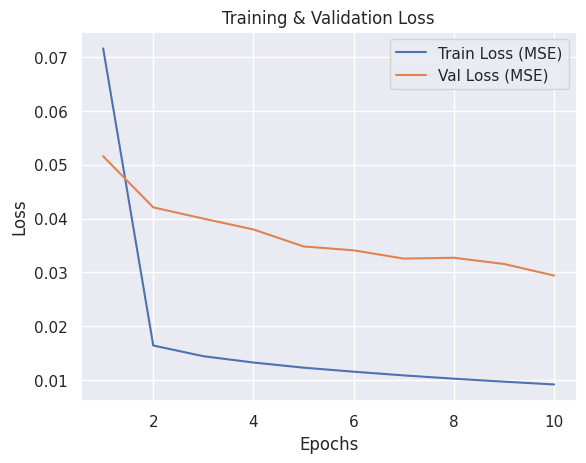

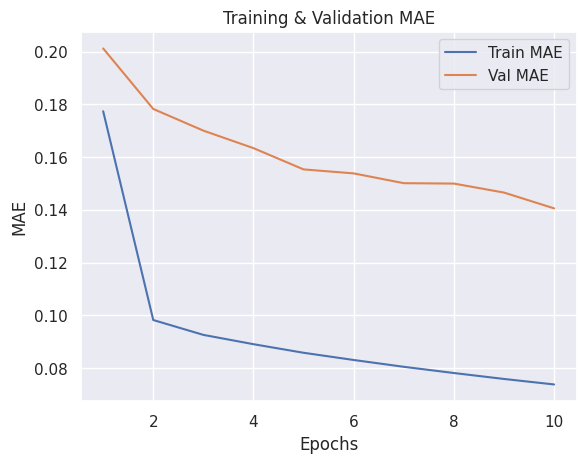

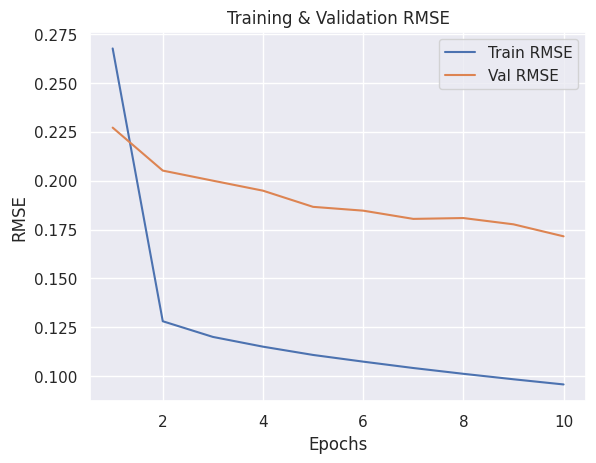

In [45]:
plot_loss(history_dict)

In [46]:
#### REFINING MODEL
def build_model2(X,X_val,num_input,num_cols):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    num_input = num_input[num_cols]

    state_input_dim = int(max(X['state_ansi'].max(), X_val['state_ansi'].max()) + 1)
    county_input_dim = int(max(X['state_county_id'].max(), X_val['state_county_id'].max()) + 1)
    dist_input_dim = int(max(X['ag_district_code'].max(), X_val['ag_district_code'].max()) + 1)

    ## add embededded inputs here

    state_input = Input(shape=(1,), name='state_ansi')
    county_input = Input(shape=(1,), name='state_county_id')
    district_input = Input(shape=(1,), name='ag_district_code')

    state_embed = Embedding(input_dim=state_input_dim, output_dim=3)(state_input)
    district_embed = Embedding(input_dim=dist_input_dim, output_dim=30)(district_input)
    county_embed = Embedding(input_dim=county_input_dim, output_dim=4)(county_input)


    county_embed = Flatten()(county_embed)
    state_embed = Flatten()(state_embed)
    district_embed = Flatten()(district_embed)

    # all numeric inputs here

    numeric_input = Input(shape=(num_input.shape[1],), name='numeric_input')

    x = Concatenate()([county_embed,district_embed,numeric_input])

    # Begin with hidden layers
    # x = Dense(units = 64, activation='relu')(x)
    # x = Dense(units = 32, activation='relu')(x)

    x = Dense(units = 256, activation='relu')(x)
    x = Dense(units = 128, activation='relu')(x)
    x = Dropout(rate = 0.5)(x)
    x = Dense(units = 64, activation='relu')(x)
    x = Dropout(rate = 0.3)(x)
    # x = Dense(units = 32, activation='relu')(x)
    # x = Dropout(rate = 0.3)(x)


    # Output
    Yield = Dense(units=1, activation='linear', name='Yield')(x)

    ## build_model
    model = tf.keras.Model(inputs=[county_input,district_input,numeric_input],
                         outputs=Yield,
                         name='Yield_1_fx')

    ## model_compile

    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00015),
                  loss="mse",
                  metrics=[
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.RootMeanSquaredError(name='mse')
        ])

    return model

In [47]:
### Fit the model
def model_fit2(model,X,X_num,X_val,Y,Y_val,num_cols):
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  # confirm data types
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=20,
                                                    restore_best_weights=True)
  embedding_cols = ["state_ansi", "state_county_id","ag_district_code"]
  for col in embedding_cols:
      X[col] = X[col].astype(np.int32)
      X_val[col] = X_val[col].astype(np.int32)

  # Ensure float type for numeric inputs and targets
  numeric_cols = [col for col in X_num.columns if col not in embedding_cols]
  X[numeric_cols] = X[numeric_cols].astype(np.float32)
  X_val[numeric_cols] = X_val[numeric_cols].astype(np.float32)

  Y = Y.astype(np.float32)
  Y_val = Y_val.astype(np.float32)


  #display(tf.keras.utils.plot_model(model))

  print("b4 history:",X.columns)

  history_7 = model.fit(
      x={
            #"state_ansi": X["state_ansi"].values,
            "state_county_id": X["state_county_id"].values,
            "ag_district_code": X["ag_district_code"].values,
            "numeric_input": X[num_cols].values
        },
        y=Y["yield_bu_acre"].values,
        epochs=100,
        batch_size=32,
        validation_data=(
            {
                #"state_ansi": X_val["state_ansi"].values,
                "state_county_id": X_val["state_county_id"].values,
                "ag_district_code": X_val["ag_district_code"].values,
                "numeric_input": X_val[num_cols].values
                },
            Y_val[['yield_bu_acre']]),
      callbacks=[early_stopping],
      verbose=1
      )
  return history_7,history_7.history


In [48]:
# Compute mean of training target
Y_mean = Y_train_cols_clean.mean()

# Scale
Y_train_scaled = Y_train_cols_clean / Y_mean
Y_val_scaled = Y_val_cols_clean / Y_mean

#numeric_cols
## cols options: "summer_rain_sum", "summer_rain_avg","spring_temp_avg", "fall_temp_avg","stacked_genes", "all_ge_var"
num_cols = ["stacked_genes", "all_ge_var"]

model_2_fit, history2 = model_fit2(build_model2(X_train_scaled_df, X_val_scaled_df,X_train_numeric,num_cols),
                       X_train_scaled_df,
                       X_train_numeric,
                       X_val_scaled_df,
                       Y_train_scaled,
                       Y_val_scaled,
                       num_cols)

b4 history: Index(['summer_rain_sum', 'summer_rain_avg', 'spring_temp_avg',
       'fall_temp_avg', 'stacked_genes', 'all_ge_var', 'state_ansi',
       'county_ansi', 'ag_district_code', 'state_county', 'state_county_id'],
      dtype='object')
Epoch 1/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3355 - mae: 0.4715 - mse: 0.5576 - rmse: 0.5576 - val_loss: 0.0452 - val_mae: 0.1798 - val_mse: 0.2127 - val_rmse: 0.2127
Epoch 2/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0686 - mae: 0.2079 - mse: 0.2619 - rmse: 0.2619 - val_loss: 0.0462 - val_mae: 0.1830 - val_mse: 0.2149 - val_rmse: 0.2149
Epoch 3/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0593 - mae: 0.1941 - mse: 0.2435 - rmse: 0.2435 - val_loss: 0.0388 - val_mae: 0.1676 - val_mse: 0.1970 - val_rmse: 0.1970
Epoch 4/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0484 - mae: 0.1730 - mse: 0.2201 - rmse: 0.2201 - val_loss: 0.0244 - val_mae: 0.1269 - val_mse: 0.1562 - val_rmse: 0.1562
Epoch 5/100
389

In [49]:
history_dict = history2
final_train_loss = history_dict["loss"][-1]
print(f"Final Training Loss: {final_train_loss:.4f}")
Y_mean_scalar = float(Y_mean.iloc[0])

if "mae" in history_dict and "val_mae" in history_dict:
    final_train_mae_norm = history_dict["mae"][-1]
    final_val_mae_norm = history_dict["val_mae"][-1]

    final_train_mae_orig = final_train_mae_norm * Y_mean_scalar
    final_val_mae_orig = final_val_mae_norm * Y_mean_scalar

if "mse" in history_dict and "val_mse" in history_dict:
    final_train_mse_norm = history_dict["mse"][-1]
    final_val_mse_norm = history_dict["val_mse"][-1]

    final_train_mse_orig = final_train_mse_norm * (Y_mean_scalar ** 2)
    final_val_mse_orig = final_val_mse_norm * (Y_mean_scalar ** 2)

if "rmse" in history_dict and "val_rmse" in history_dict:
    final_train_rmse_norm = history_dict["rmse"][-1]
    final_val_rmse_norm = history_dict["val_rmse"][-1]

    final_train_rmse_orig = final_train_rmse_norm * (Y_mean_scalar)
    final_val_rmse_orig = final_val_rmse_norm * (Y_mean_scalar)

    print("Accuracy Comparison")

    generalization_ratio_norm = final_val_mae_norm / final_train_mae_norm
    print(f"\nGeneralization Ratio (normalized MAE): {generalization_ratio_norm:.2f}x")

    print(f"\nFinal Training MSE (normalized): {final_train_mse_norm:.4f}")
    print(f"Final Validation MSE (normalized): {final_val_mse_norm:.4f}")

    print(f"\nFinal Training MSE (original): {final_train_mse_orig:.2f} (bu/acre)²")
    print(f"Final Validation MSE (original): {final_val_mse_orig:.2f} (bu/acre)²")

    print(f"\nFinal Training RMSE (normalized): {final_train_rmse_norm:.4f}")
    print(f"Final Validation RMSE (normalized): {final_val_rmse_norm:.4f}")

    print(f"\nFinal Training RMSE (original): {final_train_rmse_orig:.2f} bu/acre")
    print(f"Final Validation RMSE (original): {final_val_rmse_orig:.2f} bu/acre")

    print(f"\nFinal Training MAE - avg % error vs. mean yield: {final_train_mae_norm * 100:.2f}%")
    print(f"Final Validation MAE (normalized): {final_val_mae_norm*100:.2f}%")

    print(f"\nFinal Training MAE (original): {final_train_mae_orig:.2f} bu/acre")
    print(f"Final Validation MAE (original): {final_val_mae_orig:.2f} bu/acre")

Final Training Loss: 0.0177
Accuracy Comparison

Generalization Ratio (normalized MAE): 1.08x

Final Training MSE (normalized): 0.1330
Final Validation MSE (normalized): 0.1348

Final Training MSE (original): 3266.27 (bu/acre)²
Final Validation MSE (original): 3310.00 (bu/acre)²

Final Training RMSE (normalized): 0.1330
Final Validation RMSE (normalized): 0.1348

Final Training RMSE (original): 20.84 bu/acre
Final Validation RMSE (original): 21.12 bu/acre

Final Training MAE - avg % error vs. mean yield: 10.16%
Final Validation MAE (normalized): 10.96%

Final Training MAE (original): 15.92 bu/acre
Final Validation MAE (original): 17.17 bu/acre


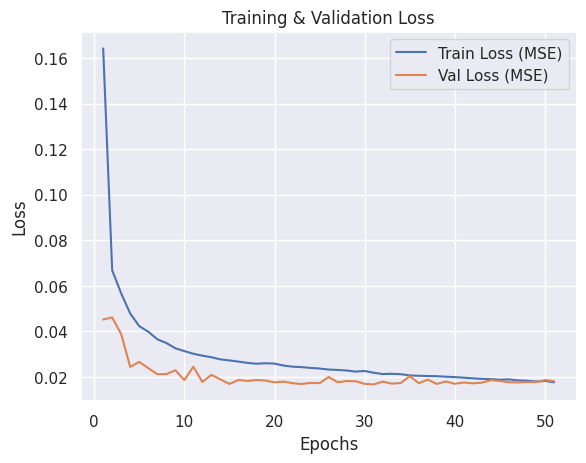

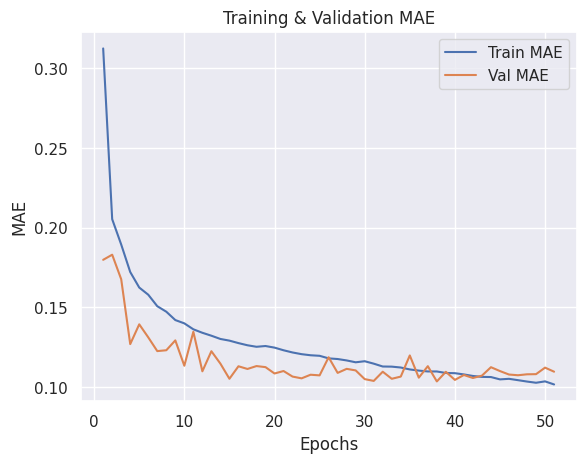

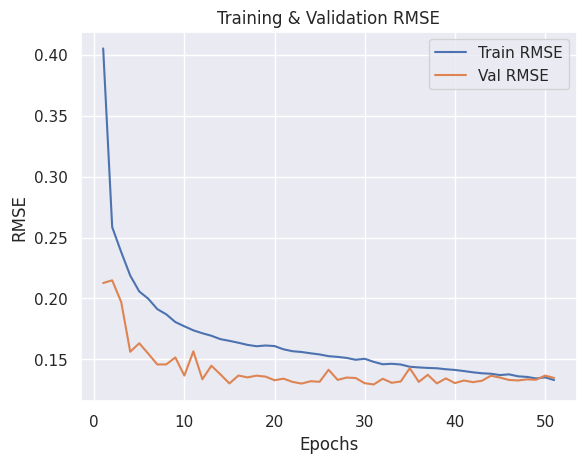

In [50]:
plot_loss(history_dict)

In [51]:
Y_train_standard_deviation = np.std(Y_train_cols_clean)
print("Y_train STD:",Y_train_standard_deviation)

Y_train STD: yield_bu_acre    32.597064
dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [52]:
y_baseline = np.full_like(Y_val_cols_clean, fill_value=np.mean(Y_train_cols_clean))

y_baseline.shape


(1092, 1)

In [53]:

mse_baseline = mean_squared_error(Y_val_cols_clean, y_baseline)
RMSE_baseline = np.sqrt(mse_baseline)
baseline_mae = mean_absolute_error(Y_val_cols_clean, y_baseline)


print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"Baseline RMSE: {RMSE_baseline:.4f}")


Baseline MAE: 34.4995
Baseline RMSE: 39.5707


In [55]:
# Scale test target using the same Y_mean from training
Y_test_scaled = Y_test_cols_clean / Y_mean

# Get the trained model from the history object
trained_model = model_2_fit.model

# Prepare test data in the same format as training
# Using only the inputs that your model actually expects based on model_fit2
test_data = {
    "state_county_id": X_test_scaled_df["state_county_id"].values.astype(np.int32),
    "ag_district_code": X_test_scaled_df["ag_district_code"].values.astype(np.int32),
    "numeric_input": X_test_numeric[num_cols].values.astype(np.float32)  # num_cols = ["stacked_genes", "all_ge_var"]
}

print(f"Test data shapes:")
print(f"state_county_id: {test_data['state_county_id'].shape}")
print(f"ag_district_code: {test_data['ag_district_code'].shape}")
print(f"numeric_input: {test_data['numeric_input'].shape}")
print(f"Y_test_scaled: {Y_test_scaled.shape}")

# Run predictions on test set
test_predictions_scaled = trained_model.predict(test_data)

# Convert predictions back to original scale
Y_mean_scalar = float(Y_mean.iloc[0])
test_predictions_orig = test_predictions_scaled * Y_mean_scalar
Y_test_orig = Y_test_cols_clean

# Calculate test metrics (scaled)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define metrics configuration for dynamic processing
test_metrics_config = {
    "mae": {"scaling": Y_mean_scalar, "units": "bu/acre", "calc_func": mean_absolute_error},
    "mse": {"scaling": Y_mean_scalar ** 2, "units": "(bu/acre)²", "calc_func": mean_squared_error},
    "rmse": {"scaling": Y_mean_scalar, "units": "bu/acre", "calc_func": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))}
}

# Calculate all test metrics dynamically
test_computed_metrics = {}
for metric_name, config in test_metrics_config.items():
    # Calculate normalized metric
    metric_norm = config["calc_func"](Y_test_scaled["yield_bu_acre"], test_predictions_scaled.flatten())

    # Convert to original scale
    metric_orig = metric_norm * config["scaling"]

    # Store results
    test_computed_metrics[metric_name] = {
        "norm": metric_norm,
        "orig": metric_orig,
        "units": config["units"]
    }

# Print test results
print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)

print(f"Test set size: {Y_test_scaled.shape[0]} samples")
print(f"Target mean (original scale): {Y_mean_scalar:.2f} bu/acre")

# Print normalized metrics
print()
for metric_name, values in test_computed_metrics.items():
    print(f"Test {metric_name.upper()} (normalized): {values['norm']:.4f}")

# Print original scale metrics
print()
for metric_name, values in test_computed_metrics.items():
    print(f"Test {metric_name.upper()} (original): {values['orig']:.2f} {values['units']}")

# Print percentage error for MAE
if "mae" in test_computed_metrics:
    print(f"\nTest MAE - avg % error vs. mean yield: {test_computed_metrics['mae']['norm'] * 100:.2f}%")

# Compare to validation performance (only if computed_metrics is available)
if 'computed_metrics' in locals() and computed_metrics:
    print("\n" + "=" * 60)
    print("COMPARISON: Validation vs Test Performance")
    print("=" * 60)

    validation_ratios = {}

    for metric_name in test_computed_metrics.keys():
        if metric_name in computed_metrics:
            # Use dynamic validation values
            val_norm = computed_metrics[metric_name]["val_norm"]
            val_orig = computed_metrics[metric_name]["val_orig"]
            test_norm = test_computed_metrics[metric_name]["norm"]
            test_orig = test_computed_metrics[metric_name]["orig"]
            units = test_computed_metrics[metric_name]["units"]

            # Calculate ratio
            ratio = test_norm / val_norm
            validation_ratios[metric_name] = ratio

            # Print comparison
            metric_upper = metric_name.upper()
            print(f"Validation {metric_upper} (normalized): {val_norm:.4f} ({val_norm*100:.2f}%)")
            print(f"Test {metric_upper} (normalized): {test_norm:.4f} ({test_norm*100:.2f}%)")
            print(f"Test/Validation {metric_upper} ratio: {ratio:.2f}x")

            print(f"\nValidation {metric_upper} (original): {val_orig:.2f} {units}")
            print(f"Test {metric_upper} (original): {test_orig:.2f} {units}")
            print()

    # Performance assessment (only if we have validation ratios)
    if validation_ratios:
        print("=" * 60)
        print("GENERALIZATION ASSESSMENT")
        print("=" * 60)

        # Use MAE ratio for assessment if available, otherwise first available metric
        assessment_ratio = validation_ratios.get("mae", list(validation_ratios.values())[0])
        assessment_metric = "mae" if "mae" in validation_ratios else list(validation_ratios.keys())[0]

        if assessment_ratio < 1.1:
            print("✅ EXCELLENT generalization - Test performance matches validation!")
        elif assessment_ratio < 1.2:
            print("✅ GOOD generalization - Minimal performance drop on test set")
        elif assessment_ratio < 1.3:
            print("⚠️  ACCEPTABLE generalization - Moderate performance drop")
        elif assessment_ratio < 1.5:
            print("⚠️  CONCERNING generalization - Significant performance drop")
        else:
            print("❌ POOR generalization - Major overfitting detected")

        print(f"\nModel Performance Summary:")

        # Use dynamic values only
        if "mae" in computed_metrics:
            train_mae_pct = computed_metrics["mae"]["train_norm"] * 100
            train_mae_orig = computed_metrics["mae"]["train_orig"]
            val_mae_pct = computed_metrics["mae"]["val_norm"] * 100
            val_mae_orig = computed_metrics["mae"]["val_orig"]
            train_val_ratio = computed_metrics["mae"]["val_norm"] / computed_metrics["mae"]["train_norm"]

            test_mae_pct = test_computed_metrics["mae"]["norm"] * 100
            test_mae_orig = test_computed_metrics["mae"]["orig"]
            val_test_ratio = validation_ratios["mae"]

            print(f"• Training MAE: {train_mae_pct:.2f}% ({train_mae_orig:.2f} bu/acre)")
            print(f"• Validation MAE: {val_mae_pct:.2f}% ({val_mae_orig:.2f} bu/acre)")
            print(f"• Test MAE: {test_mae_pct:.2f}% ({test_mae_orig:.2f} bu/acre)")
            print(f"• Train→Val generalization: {train_val_ratio:.2f}x")
            print(f"• Val→Test generalization: {val_test_ratio:.2f}x")

            if test_mae_pct < 12:
                print(f"\n🎯 Your model achieves <12% error rate - excellent for agricultural prediction!")
            else:
                print(f"\n📊 Model performance: {test_mae_pct:.1f}% error rate")

else:
    print("\n⚠️  computed_metrics not available - run the dynamic validation analysis first to get comparison ratios")

Test data shapes:
state_county_id: (446,)
ag_district_code: (446,)
numeric_input: (446, 2)
Y_test_scaled: (446, 1)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

TEST SET RESULTS
Test set size: 446 samples
Target mean (original scale): 156.72 bu/acre

Test MAE (normalized): 0.1094
Test MSE (normalized): 0.0179
Test RMSE (normalized): 0.1337

Test MAE (original): 17.14 bu/acre
Test MSE (original): 439.28 (bu/acre)²
Test RMSE (original): 20.96 bu/acre

Test MAE - avg % error vs. mean yield: 10.94%

⚠️  computed_metrics not available - run the dynamic validation analysis first to get comparison ratios
